<a href="https://colab.research.google.com/github/Batulnasser24/Resnet18/blob/main/Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# التأكد من استخدام الـ GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# 1. التحويلات (Data Augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. تحميل CIFAR-10 كاملة
full_train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 3. إنشاء نسخة "البيانات الصغيرة" (10% من البيانات)
indices = list(range(len(full_train_set)))
np.random.shuffle(indices)
small_split = int(0.1 * len(full_train_set))
small_train_indices = indices[:small_split]
small_train_set = Subset(full_train_set, small_train_indices)

# 4. الـ Data Loaders
small_loader = DataLoader(small_train_set, batch_size=64, shuffle=True)
large_loader = DataLoader(full_train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

print(f"Small dataset size: {len(small_train_set)}")
print(f"Large dataset size: {len(full_train_set)}")

100%|██████████| 170M/170M [00:03<00:00, 48.7MB/s]


Small dataset size: 5000
Large dataset size: 50000


In [3]:
def get_resnet_model(freeze=True):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    if freeze:
        for param in model.parameters():
            param.requires_grad = False  # تجميد كل الطبقات

    # استبدال الطبقة الأخيرة (ستكون قابلة للتدريب دائماً)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    return model.to(device)

def train_experiment(model, loader, epochs=3, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    # نمرر فقط المعاملات التي تتطلب اشتقاق (نحتاجها في حالة التجميد)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        print(f"Epoch {epoch+1} | Acc: {100.*correct/total:.2f}%")

    duration = time.time() - start_time
    return duration, 100.*correct/total

In [4]:
results = {}

# التجربة 1: تجميد الطبقات + بيانات صغيرة
print("\n--- Exp 1: Frozen + Small Dataset ---")
model_1 = get_resnet_model(freeze=True)
results['Frozen_Small'] = train_experiment(model_1, small_loader)

# التجربة 2: إعادة تدريب الكل + بيانات صغيرة
print("\n--- Exp 2: Unfrozen + Small Dataset ---")
model_2 = get_resnet_model(freeze=False)
results['Unfrozen_Small'] = train_experiment(model_2, small_loader, lr=0.0001)

# التجربة 3: تجميد الطبقات + بيانات كبيرة
print("\n--- Exp 3: Frozen + Large Dataset ---")
model_3 = get_resnet_model(freeze=True)
results['Frozen_Large'] = train_experiment(model_3, large_loader)

# التجربة 4: إعادة تدريب الكل + بيانات كبيرة
print("\n--- Exp 4: Unfrozen + Large Dataset ---")
model_4 = get_resnet_model(freeze=False)
results['Unfrozen_Large'] = train_experiment(model_4, large_loader, lr=0.0001)


--- Exp 1: Frozen + Small Dataset ---
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]


Epoch 1 | Acc: 48.94%
Epoch 2 | Acc: 71.84%
Epoch 3 | Acc: 76.34%

--- Exp 2: Unfrozen + Small Dataset ---
Epoch 1 | Acc: 72.14%
Epoch 2 | Acc: 94.48%
Epoch 3 | Acc: 99.06%

--- Exp 3: Frozen + Large Dataset ---
Epoch 1 | Acc: 72.86%
Epoch 2 | Acc: 78.87%
Epoch 3 | Acc: 79.57%

--- Exp 4: Unfrozen + Large Dataset ---
Epoch 1 | Acc: 89.31%
Epoch 2 | Acc: 96.94%
Epoch 3 | Acc: 98.67%



EXPERIMENT SUMMARY
Frozen_Small    | Time: 40.02s | Final Train Acc: 76.34%
Unfrozen_Small  | Time: 67.06s | Final Train Acc: 99.06%
Frozen_Large    | Time: 381.32s | Final Train Acc: 79.57%
Unfrozen_Large  | Time: 676.61s | Final Train Acc: 98.67%


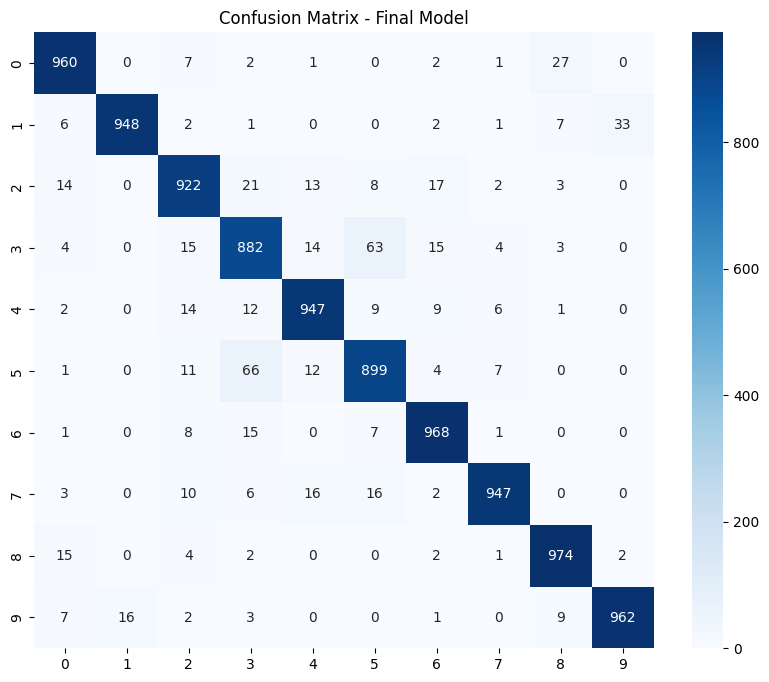

In [5]:
# طباعة ملخص النتائج
print("\n" + "="*30)
print("EXPERIMENT SUMMARY")
print("="*30)
for exp, (time_taken, acc) in results.items():
    print(f"{exp:15} | Time: {time_taken:.2f}s | Final Train Acc: {acc:.2f}%")

# رسم Confusion Matrix لآخر موديل كمثال
def plot_cm(model):
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Final Model')
    plt.show()

plot_cm(model_4)

# 📑   نتائج  المشروع  

## 1. مقارنة أوضاع التدريب (Training Modes)

### 🔹 أولاً: حالة تجميد الطبقات (Frozen Head)
* **آلية العمل:** يتم تثبيت أوزان النموذج المسبق التدريب (ResNet18) وتدريب الطبقة الأخيرة (FC Layer) فقط.
* **زمن التدريب:** قصير جداً؛ لأن عدد المعاملات (Parameters) التي يتم تحديثها محدود.
* **الأداء:** دقة جيدة ومستقرة، وهي الطريقة الأنسب عند امتلاك موارد حوسبة ضعيفة أو وقت محدود.

### 🔹 ثانياً: حالة تدريب النموذج كاملاً (Unfrozen / Retrain)
* **آلية العمل:** السماح بتحديث جميع أوزان النموذج بما يتناسب مع البيانات الجديدة.
* **زمن التدريب:** طويل جداً؛ بسبب الحاجة لمعالجة وتحديث ملايين الأوزان في كل دورة (Epoch).
* **الأداء:** يمنح النموذج مرونة عالية وقدرة أكبر على تخصيص الميزات (Features) للبيانات الجديدة، مما يؤدي لدقة أعلى.

---

## 2. تأثير حجم البيانات (Data Size Impact)

| حجم البيانات | وضع التجميد (Frozen) | وضع التدريب الكامل (Unfrozen) |
| :--- | :--- | :--- |
| **بيانات صغيرة (Small)** | **الأفضل:** يحمي من الـ Overfitting ويعطي نتائج مستقرة. | **خطر:** قد يؤدي لفرط التخصيص (Overfitting) وفشل التعميم. |
| **بيانات كبيرة (Large)** | **سريع:** يعطي دقة مقبولة جداً في وقت قياسي. | **الأقوى:** يستغل وفرة البيانات للوصول لأقصى دقة ممكنة. |

---

## 3. ملخص الاستنتاجات (Final Insights)

1.  **الأداء الأقصى:** يتحقق عند دمج **(Unfrozen + Large Dataset)**، حيث يمتلك النموذج المرونة والبيانات الكافية للتعلم.
2.  **الكفاءة الزمنية:** وضع **Frozen** يتفوق دائماً في السرعة بغض النظر عن حجم البيانات.
3.  **التوصية التقنية:** للمشاريع الحقيقية، يُفضل البدء بـ **Frozen** لضبط الرأس الجديد، ثم **Unfrozen** مع معدل تعلم منخفض جداً (Fine-tuning) لتحسين النتائج النهائية.